### Imports and config

In [1]:
# Libraries
import os
from importlib import reload

import keras
import sklearn.model_selection
import numpy as np
import matplotlib.pyplot as plt

# Scripts
from helpers import data, runners, utils, generators

In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
!pip show keras

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [4]:
reload(data)
reload(runners)
reload(utils)

<module 'helpers.utils' from 'c:\\Users\\sonar\\Desktop\\thesis-ml\\ml\\main\\helpers\\utils.py'>

In [5]:
# Silence information messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
# utils.check_gpu_use() 

## `main`

### Load data

In [6]:
SPECS_DIR = "../data/image_segmentation/data/spectrograms"
MASKS_DIR = "../data/image_segmentation/data/masks"

IMAGE_DIMS = (256, 256)
MODEL_INPUT_SIZE = (256, 256, 1)
DATA_BATCH_SIZE = 8
GPU_BATCH_SIZE = 8
NUM_EPOCHS = 500

In [7]:
def clean_dirs(specs_dir, masks_dir):
    # Get sorted lists of image and mask files
    spec_files = sorted([f for f in os.listdir(specs_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('.png')])

    # Keep only spec_files that have a corresponding mask
    mask_ids = {f.replace('_mask.png', '') for f in mask_files}
    spec_files = [f for f in spec_files if f.replace('.png', '') in mask_ids]

    return spec_files, mask_files

In [8]:
spec_files, mask_files = clean_dirs(SPECS_DIR, MASKS_DIR)
train_specs, test_specs, train_masks, test_masks = \
    sklearn.model_selection.train_test_split(spec_files, mask_files, test_size=0.2, random_state=42)

train_gen = generators.ImageSegmentationGenerator(
    SPECS_DIR, MASKS_DIR, 
    train_specs, train_masks, 
    batch_size=DATA_BATCH_SIZE, 
    image_dims=IMAGE_DIMS, 
    shuffle=True
)

test_gen = generators.ImageSegmentationGenerator(
    SPECS_DIR, MASKS_DIR, 
    test_specs, test_masks, 
    batch_size=DATA_BATCH_SIZE, 
    image_dims=IMAGE_DIMS, 
    shuffle=True
)

### Configure model

In [9]:
from models import unetpro, unet

NUM_CLASSES = 1

# model = unetpro.get_unetpro_model(input_size=MODEL_INPUT_SIZE, classes=NUM_CLASSES, dropout=0.1)
model = unet.get_unet_model(input_shape=MODEL_INPUT_SIZE, classes=NUM_CLASSES)

metrics = [
    keras.metrics.BinaryAccuracy(), 
    keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
]

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-5), 
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

c:\Users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Train model

In [10]:
# Train the model
history = model.fit(
    train_gen,
    epochs=NUM_EPOCHS,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

Epoch 1/500
35/35 - 54s - loss: 1.5037 - binary_accuracy: 0.9022 - binary_io_u: 0.0000e+00 - 54s/epoch - 2s/step
Epoch 2/500
35/35 - 46s - loss: 0.4636 - binary_accuracy: 0.9032 - binary_io_u: 0.0000e+00 - 46s/epoch - 1s/step
Epoch 3/500
35/35 - 45s - loss: 0.2952 - binary_accuracy: 0.9034 - binary_io_u: 0.0000e+00 - 45s/epoch - 1s/step
Epoch 4/500
35/35 - 46s - loss: 0.2913 - binary_accuracy: 0.9029 - binary_io_u: 0.0000e+00 - 46s/epoch - 1s/step
Epoch 5/500
35/35 - 46s - loss: 0.2880 - binary_accuracy: 0.9028 - binary_io_u: 0.0000e+00 - 46s/epoch - 1s/step
Epoch 6/500
35/35 - 47s - loss: 0.2834 - binary_accuracy: 0.9025 - binary_io_u: 0.0000e+00 - 47s/epoch - 1s/step
Epoch 7/500
35/35 - 51s - loss: 0.2773 - binary_accuracy: 0.9028 - binary_io_u: 0.0000e+00 - 51s/epoch - 1s/step
Epoch 8/500
35/35 - 48s - loss: 0.2649 - binary_accuracy: 0.9029 - binary_io_u: 0.0000e+00 - 48s/epoch - 1s/step
Epoch 9/500
35/35 - 46s - loss: 0.2519 - binary_accuracy: 0.9026 - binary_io_u: 0.0043 - 46s/epo

In [11]:
model.save("models/saved/unet_segmentation_500_epochs.keras")

### Evaluate model

In [12]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

9/9 - 4s - loss: 0.3827 - binary_accuracy: 0.9397 - binary_io_u: 0.4930 - 4s/epoch - 392ms/step


1/1 [==============================] - 0s 27ms/step


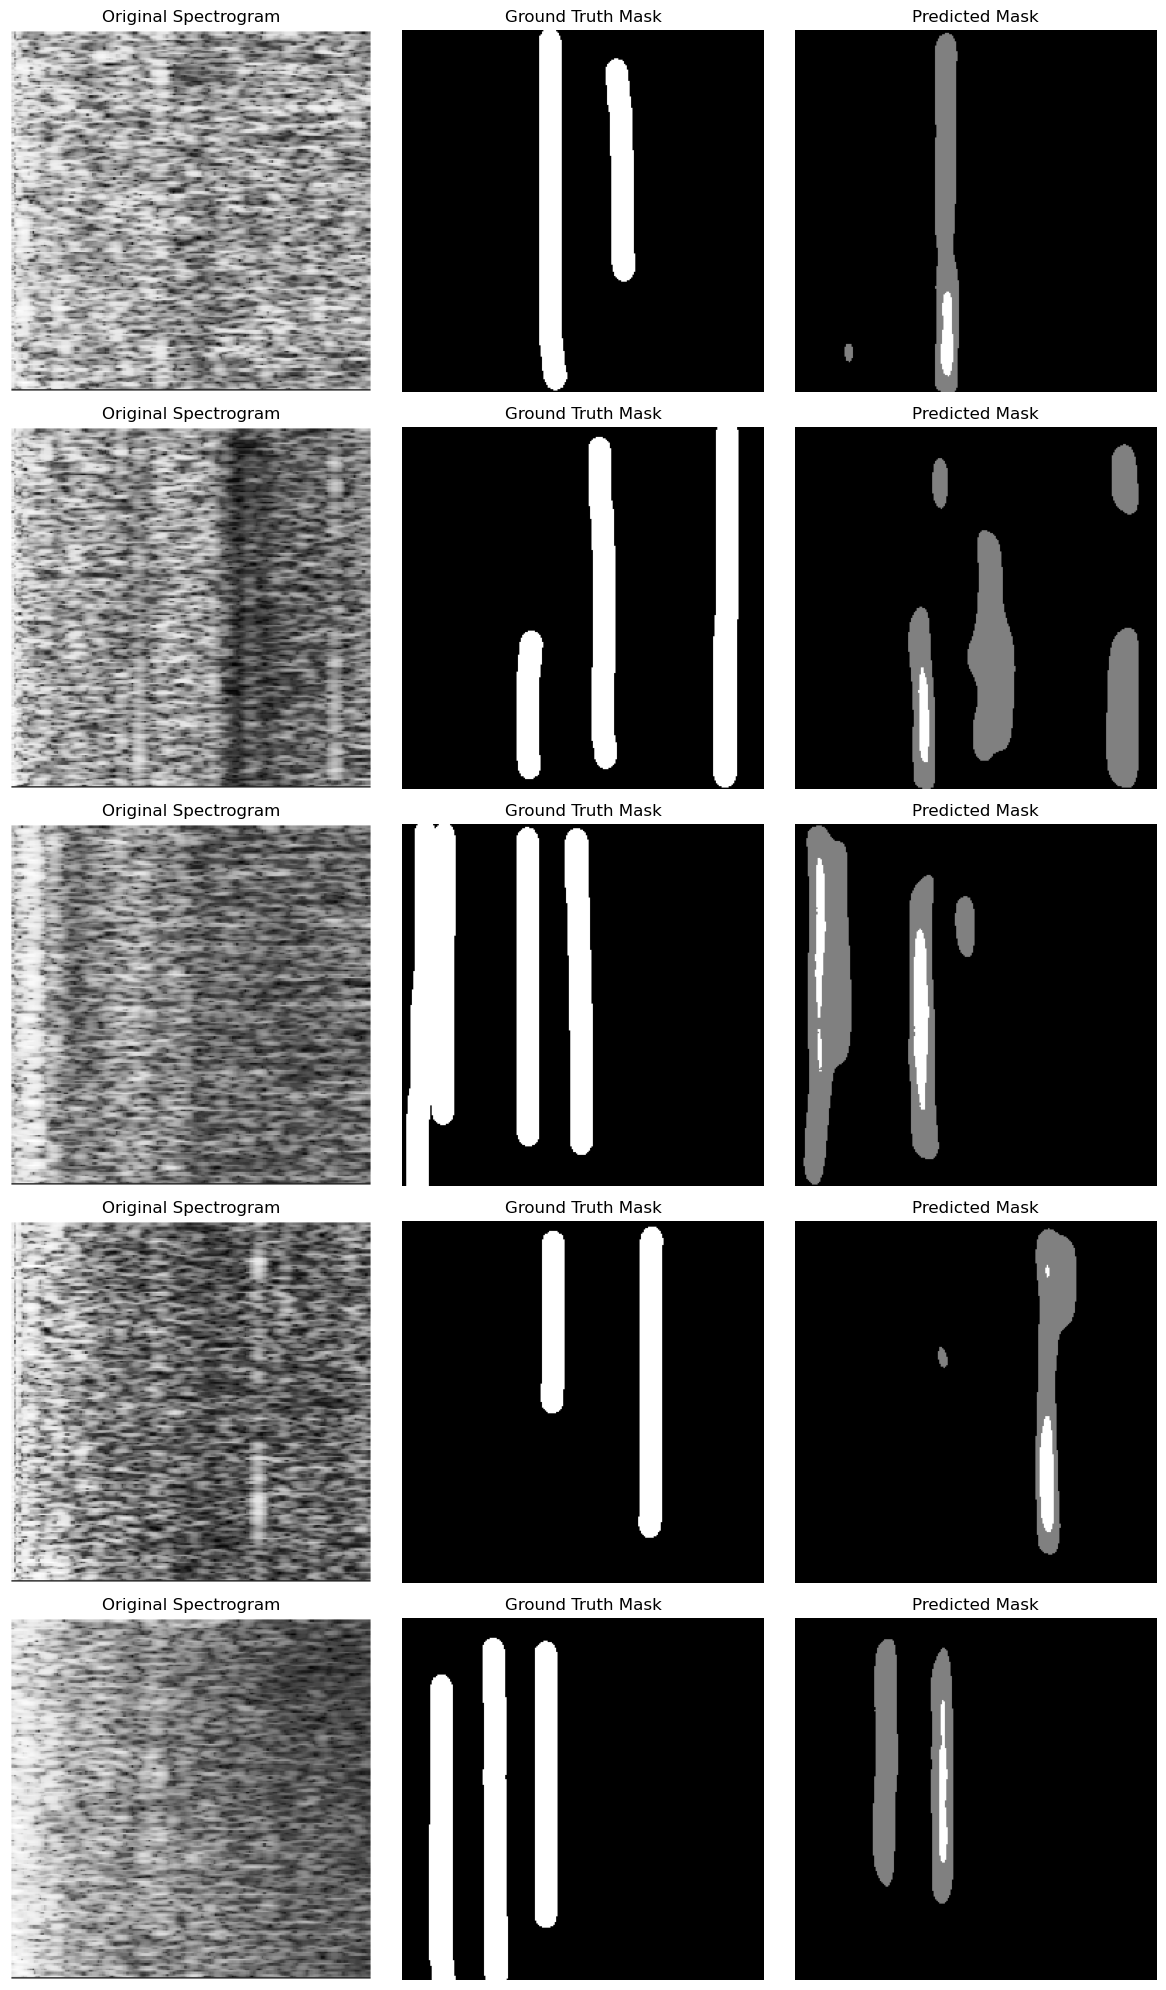

In [16]:
def visualise_predictions(model, test_gen, num_samples=5):
    """
    Visualises predictions made by the model on samples from the test generator.

    :param model: Trained Keras model for segmentation.
    :param test_gen: The test generator for loading data.
    :param num_samples: Number of samples to visualise.
    """
    specs, true_masks = test_gen.__getitem__(5)  
    preds = model.predict(specs)

    # Round the predictions to binary values
    preds = np.round(preds)

    plt.figure(figsize=(12, num_samples * 4))
    for i in range(num_samples):
        spec = specs[i].squeeze()          
        true_mask = true_masks[i].squeeze() 
        pred_mask = preds[i].squeeze()      

        # Plot original spectrogram
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(spec, cmap="gray")
        plt.title("Original Spectrogram")
        plt.axis("off")

        # Plot ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Plot predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("models/saved/unet_segmentation_500_epochs.png")
    plt.show()

visualise_predictions(model, test_gen, num_samples=5)